#### - Retail Sales: Clothing and Clothing Accessory Stores

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [6]:
df = pd.read_csv("RSCCASN.csv", 
                index_col = "DATE",
                parse_dates = True)
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21175
2019-07-01,21800
2019-08-01,23906


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [8]:
df.columns = ["Sales"]

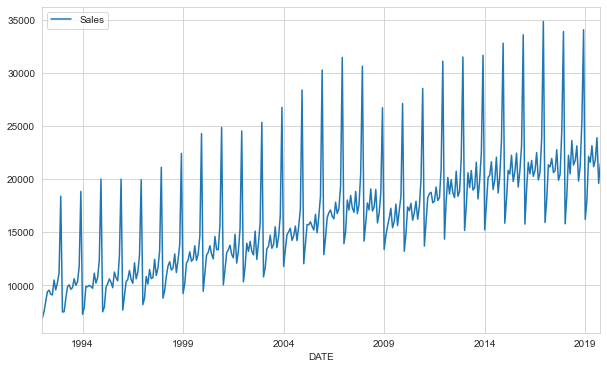

In [9]:
df.plot();

- her bir saykılım 12 datadan oluşuyor. test datamı 12 den fazla belirlemeliyim. 12 den az belirlersem örüntü yapamaz

## Preprocessing of Data

### Train Test Split

In [10]:
len(df)

334

In [11]:
len(df) - 18

316

In [12]:
test_size = 18
# datamdaki saykıl 12 olduğu için bu rakamdan büyük bir test size belirledim.
# test datası ile validation yaparken saykıl olan 12yi bundan çıkarınca geriye 6 kalacak. 6 data ile predict yapacak.

In [13]:
test_ind = len(df) - test_size
test_ind

316

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33901
2018-01-01,15803
2018-02-01,18451


In [15]:
test

,Sales
DATE,
2018-05-01,23641
2018-06-01,21337
2018-07-01,21745
2018-08-01,23136
2018-09-01,19826
2018-10-01,21265
2018-11-01,25446
2018-12-01,34067
2019-01-01,16223


### Scaling

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# help(TimeseriesGenerator)

In [21]:
length = 12  # yilda bir oruntu olusturdugu icin
batch_size = 1

generator = TimeseriesGenerator(data = train_scaled,
                               targets = train_scaled,
                               length = length,
                               batch_size = batch_size)

In [22]:
generator[0]

(array([[[0.        ],
         [0.02099681],
         [0.05507184],
         [0.0882511 ],
         [0.09387653],
         [0.08040417],
         [0.07757354],
         [0.12809488],
         [0.09441399],
         [0.11881472],
         [0.1522448 ],
         [0.41051274]]]),
 array([[0.02020853]]))

In [23]:
X, y = generator[0]

In [24]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02099681 0.05507184 0.0882511  0.09387653 0.08040417
 0.07757354 0.12809488 0.09441399 0.11881472 0.1522448  0.41051274]
Predict this y: 
 [[0.02020853]]


## Modelling

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [26]:
n_features = 1

In [27]:
model = Sequential()
model.add(LSTM(128, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(1))   # 2 değeri karşılaştıracağım için çıkış layer ında 1 nöron olmalı.
model.compile(optimizer = "adam", loss = "mse")

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor = "val_loss", patience = 5)

In [33]:
validation_generator = TimeseriesGenerator(data = test_scaled,
                                          targets = test_scaled,
                                          length = length,
                                          batch_size = 1)

In [34]:
len(validation_generator)  

# 18-12 = 6 tane 

# son 18 taneyi test için ayırdık, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer üretti. 

6

In [36]:
model.fit_generator(generator, epochs = 20, 
                   validation_data = validation_generator,
                   callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 2s 3ms/step - loss: 0.0247 - val_loss: 0.0067
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0141
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 8.4022e-04
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 4.4111e-04
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 8/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 10/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss

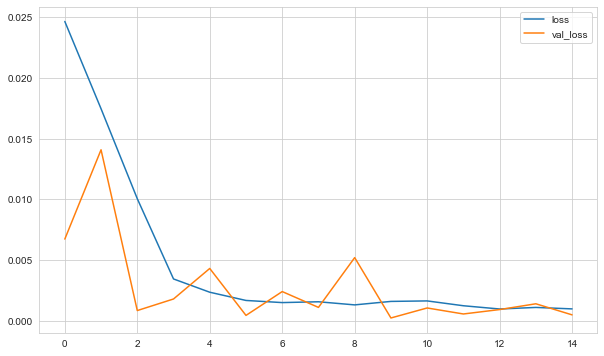

In [38]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

## Evaluate on Test Data

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [42]:
y_pred = model.predict(validation_generator)
y_pred
# son 18 taneyi test için ayırıp, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer generate etmiştik. 
    # şimdi bu değerlerin predict ini aldık.

array([[0.61168736],
       [0.53155124],
       [0.54320437],
       [0.5913284 ],
       [0.48651463],
       [0.5281632 ]], dtype=float32)

In [43]:
test_scaled[-6:]
# y_pred i test datamın son 6 sı ile kıyaslamam lazım. çünkü o predict ler onlara denk geliyor

array([[0.58095955],
       [0.51012218],
       [0.53251639],
       [0.60797592],
       [0.45390376],
       [0.52072808]])

In [44]:
eval_metrics(test_scaled[-6:], y_pred)

r2_score: 0.8036803675706 
 mae: 0.01992306190198719 
 mse: 0.0004855877124674541 
 rmse: 0.022036054829924847


In [49]:
test_prediction = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction 
    test_prediction.append(current_pred)
    
    # update batch to now include prediction adn drop first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)
    
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacağız
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

In [50]:
eval_metrics(test_scaled, test_prediction)

r2_score: 0.9706518821992732 
 mae: 0.01675302217040862 
 mse: 0.00047630774460392055 
 rmse: 0.02182447581510082


### Inverse Transformations and Comparing

In [51]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction

array([[22376.55199093],
       [21138.54751354],
       [21198.99932271],
       [23064.27366376],
       [20512.20255923],
       [21000.39167416],
       [25121.32862461],
       [34073.67597032],
       [16088.90342557],
       [18960.39763117],
       [22712.26247954],
       [21114.71113563],
       [22802.8869611 ],
       [21609.40954965],
       [21600.57965964],
       [23360.83187443],
       [21029.35165066],
       [21478.78772908]])

In [54]:
test["Prediction"] = true_prediction
test

,Sales,Prediction
DATE,,
2018-05-01,23641,22376.552
2018-06-01,21337,21138.548
2018-07-01,21745,21198.999
2018-08-01,23136,23064.274
2018-09-01,19826,20512.203
2018-10-01,21265,21000.392
2018-11-01,25446,25121.329
2018-12-01,34067,34073.676
2019-01-01,16223,16088.903


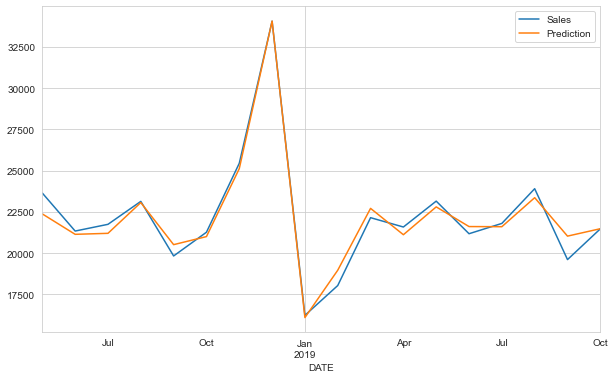

In [55]:
test.plot();

In [56]:
eval_metrics(test.Sales, test.Prediction)

r2_score: 0.9706518821992732 
 mae: 467.56009575393375 
 mse: 371001.9518074051 
 rmse: 609.0992955236487


## Retrain and Forecasting